# Model building

There are several top notch deep learning frameworks that would suffice for this task; but in this case we'll be using __Tensorflow__ from __Google__.<br> 
Training a CNN from scratch is computationally and timely expensive as a result ML engineers sometimes have to lean towards a faster and reliable process called __Transfer Learning__.<br>
In transfer learning we employ robust models that have been trained on data similar to the ones we have at hand, and perform series of fine-tuning to get a desire output. This method is computationally cheaper and also reliable.  
<br>
For this classification problem we'll employ the __Xception__ model and fine tune it appropriately. 

In [23]:
# Import necessary packages.
%matplotlib inline
import numpy as np
import absl.logging
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

# Ignoring all unnecessary warnings.
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel("ERROR")

# Important constants.
DATASET_PATH = r"../data/clean_dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 20

In [2]:
# Load the dataset with the Tensorflow data pipeline.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = (BATCH_SIZE),
)

Found 3000 files belonging to 2 classes.


2022-10-18 19:54:20.800045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
len(dataset)

375

The dataset is loaded as batches specified by the "batch_size" parameter. In this case, 3000 images batched into sizes of 8. Thus, 375 batches and that would be the length of the dataset.

The target/label_names of this dataset are the names of the sub directories in the _DATASET_PATH_ specified earlier.

In [4]:
# Gets the label names from the dataset object.
label_names = dataset.class_names
label_names

['no_tumour', 'tumour']

When one wants to train a model with a particular dataset, the normal practice is to split said dataset into separate chunks; particularly a training chunk and a testing chunk. The purpose of splitting the data is for evaluation purposes after training the model.  
Most times, ML folks use __scikit-learn's__ ___train_test_split___. In this case, we'll use the ___take___ and ___skip___ attributes of the dataset object which allows us to grab a portion of the dataset by batches.  

The training chunk is always a lot larger that the validation chunk and testing chunk, so that the model is trained on as much data as possible. We'll set aside for training, validation and testing; 80%, 10%, 10% respectively.

In [5]:
train_size = 0.8
print(f"The training dataset should be {int(len(dataset)*train_size)} batches")

The training dataset should be 300 batches


In [6]:
# Takes first 300 batches of the dataset
train_ds = dataset.take(300)
len(train_ds)

300

In [7]:
# Remaining data after the training chunk.
remnant = dataset.skip(300)
len(remnant)

75

In [8]:
val_size = 0.1
print(f"The validation dataset should be {int(len(dataset)*val_size)} batches")

The validation dataset should be 37 batches


In [9]:
# Takes the first 37 batch of the remaining data.
val_ds = remnant.take(37)
len(val_ds)

37

In [10]:
# Takes all the data after the first 37 batches.
test_ds = remnant.skip(37)
len(test_ds)

38

All of these snippets can be wrapped in a simple function.

In [11]:
def chunking(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, buffer=1000):
    """
    The purpose of this function is to split a dataset into the necessary chunks and return
    said chunks accordingly.
    
    A dataset is passed as an argument and the partitions are made with the predefined split sizes.
    One can also alter the split sizes by changing the values while calling the function.
    """
    
    number_of_batches = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(buffer, seed=321)
    
    train_size = int(train_split*number_of_batches)
    validation_size = int(validation_split*number_of_batches)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(validation_size)
    test_ds = dataset.skip(train_size).skip(validation_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = chunking(dataset)
print(f"""The dataset of 375 batches was chunked as follows: 
{len(train_ds)} batches for the Training dataset, 
{len(val_ds)} batches for the Validation dataset and, 
{len(test_ds)} batches for the Testing dataset.""")

The dataset of 375 batches was chunked as follows: 
300 batches for the Training dataset, 
37 batches for the Validation dataset and, 
38 batches for the Testing dataset.


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Caching is used to improve data retrieval performance by reducing the need to access underlying storage.  
In short, the dataset is cached in memory. This reduces training time because there will be no need open files and read images during each epoch.. The next epochs will reuse the data cached by the cache transformation.

In [14]:
# Layers for data_augmentation, resizing and rescaling.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.5),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4),
    layers.RandomBrightness([-0.5, 0.5])
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

The point of transfer learning is to reduce training time by reducing the number of trainable weights. With transfer learning, one can use the optimised weights of a pretrained model together with a few weights from series of modifications to generate a reliably accurate model. In essence, we freeze the weights of the pretrained model, then we train only a few weights from the modifications, thus, reducing computation and time cost. 

There is a crucial things one must do when employing a pretrained model, _i.e_ modifying the input and output layers of the network to achieved desired results.  
For example, the Xception network has a final output layer of 1000 classes, but we are trying to classify only two classes. Therefore, we ought to modify the output layer according to the problem at hand.

In [16]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_labels = len(label_names)



xception = Xception(input_shape=input_shape, weights='imagenet', include_top=False)
xception.trainable = False

83683744/83683744 [==============================] - 410s 5us/step


In [19]:
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = xception(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(n_labels, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

As we know, backward propagation is one of two fundamental steps in training an __NN__. We'll use Adam optimizer for backward propagation.<br>
This is a binary problem __i.e__, no tumour[0] or tumour[1], however, we'll use SparseCategoricalCrossentropy to calculate the loss of the model's prediction compared to the actual labels.<br>
Then we can track our model's performance with an accuracy metric.


__NB:__ Backward propagation is a method sort of differencial calculus where we calculate the gradient of the loss function with respect to the parameters(weights and biases). Then we update said weights and biases according to minimise the loss.

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

Viola!!!<br> 
We have only 4098 weights to train.<br>
This shouldn't take much time.

We train the model by fitting it to the training dataset and we validate its performance with the validation dataset.

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
300/300 [==============================] - 216s 707ms/step - loss: 0.7232 - accuracy: 0.7317 - val_loss: 0.5655 - val_accuracy: 0.8142
Epoch 2/20
300/300 [==============================] - 234s 781ms/step - loss: 0.6616 - accuracy: 0.7979 - val_loss: 0.3178 - val_accuracy: 0.9020
Epoch 3/20
300/300 [==============================] - 248s 826ms/step - loss: 0.8359 - accuracy: 0.7975 - val_loss: 0.5815 - val_accuracy: 0.8480
Epoch 4/20
300/300 [==============================] - 241s 802ms/step - loss: 0.6933 - accuracy: 0.8204 - val_loss: 0.2834 - val_accuracy: 0.9054
Epoch 5/20
300/300 [==============================] - 246s 821ms/step - loss: 0.7646 - accuracy: 0.8250 - val_loss: 0.2564 - val_accuracy: 0.8919
Epoch 6/20
300/300 [==============================] - 599s 2s/step - loss: 0.8051 - accuracy: 0.8238 - val_loss: 0.2649 - val_accuracy: 0.9358
Epoch 7/20
300/300 [==============================] - 294s 983ms/step - loss: 0.7781 - accuracy: 0.8400 - val_loss: 0.3920 - va

When one fits a model, the process returns a few items; that which we assigned to the ___history___ variable. Let's take a look.

In [25]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 300}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

These are the keys the training process displayed. Since we ran 100 epochs, each of these keys contain 100 items.

In [27]:
print(len(history.history['accuracy']))
history.history['accuracy']

20


[0.7316666841506958,
 0.7979166507720947,
 0.7975000143051147,
 0.8204166889190674,
 0.824999988079071,
 0.8237500190734863,
 0.8399999737739563,
 0.8174999952316284,
 0.840833306312561,
 0.8304166793823242,
 0.8316666483879089,
 0.8287500143051147,
 0.8362500071525574,
 0.8262500166893005,
 0.8295833468437195,
 0.8441666960716248,
 0.847083330154419,
 0.8329166769981384,
 0.8458333611488342,
 0.8520833253860474]

As we can see the first value corresponds with the first accuracy our model achieved in the first epoch.<br>  
Now, we can simply plot the accuracy and loss to see the improvement of the model over each epoch.

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

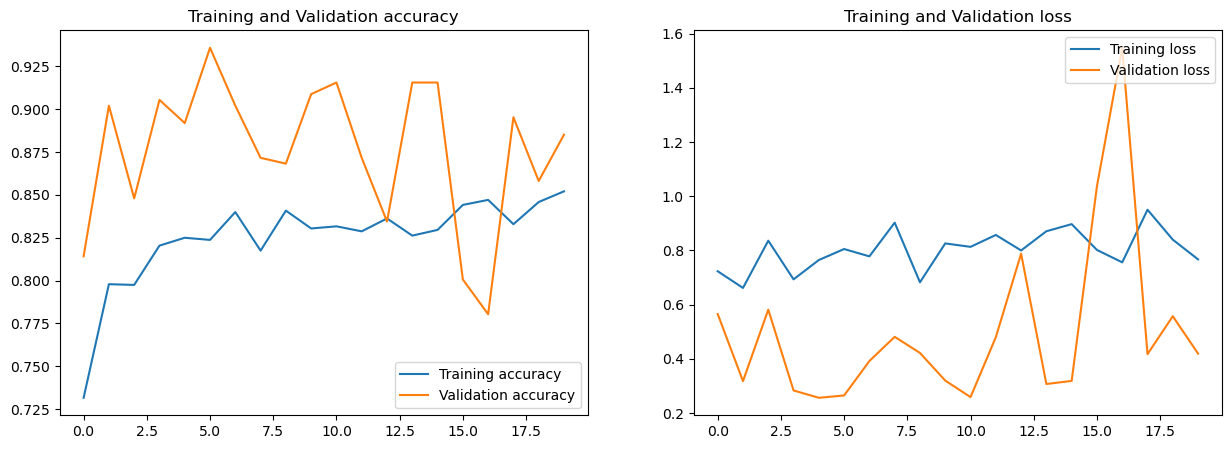

In [29]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label="Training accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

plt.show()

Well, apparently there was not much imporvement over 20 epochs. it's clear that 20 epochs was not needed. 10 would have sufficed.
#### Fine tuning
This is the interesting part of transfer learning.  
Here we would simply unfreeze some of the pretrained weights of the __Xception__ model and optimize them.  
This session will immensely improve the accuracy of the model.

In [30]:
xception.trainable = True

In [31]:
print(f"Number of layers in the Xception model : {len(xception.layers)}")

Number of layers in the Xception model : 132


The Xception model is 132 layers deep, with this I can arbitrarily chose how many layers deep I wish to start fine tuning from.  
Perhaps 95. We'll start fine tuning at the 95th layer...

In [32]:
fine_tune_at = 95

for layer in xception.layers[:fine_tune_at]:
    layer.trainable = False

In [33]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

Great!!!<br>
We'll be fine tuning over 10 million weights...

In [35]:
fine_tune_epochs = 10
total_epochs = EPOCHS+fine_tune_epochs


history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 20/30
300/300 [==============================] - 368s 1s/step - loss: 0.4425 - accuracy: 0.8504 - val_loss: 0.1717 - val_accuracy: 0.9392
Epoch 21/30
300/300 [==============================] - 404s 1s/step - loss: 0.2641 - accuracy: 0.8892 - val_loss: 0.2132 - val_accuracy: 0.9088
Epoch 22/30
300/300 [==============================] - 481s 2s/step - loss: 0.2600 - accuracy: 0.9017 - val_loss: 0.1208 - val_accuracy: 0.9493
Epoch 23/30
300/300 [==============================] - 531s 2s/step - loss: 0.1956 - accuracy: 0.9225 - val_loss: 0.1056 - val_accuracy: 0.9628
Epoch 24/30
300/300 [==============================] - 2030s 7s/step - loss: 0.1972 - accuracy: 0.9292 - val_loss: 0.1074 - val_accuracy: 0.9459
Epoch 25/30
300/300 [==============================] - 451s 2s/step - loss: 0.1757 - accuracy: 0.9321 - val_loss: 0.0944 - val_accuracy: 0.9628
Epoch 26/30
300/300 [==============================] - 388s 1s/step - loss: 0.1651 - accuracy: 0.9329 - val_loss: 0.0897 - val_accuracy

Finally, we have a model with a superb validation accuracy of 97.3%.  
Now, we can evaluate the overall performance of this model on unseen data by predicting the test dataset.

In [36]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 24s 589ms/step - loss: 0.0576 - accuracy: 0.9868


Incredible, the model performs even better on the unseen data. A phenomenal accuracy of approximately 99%.<br>  
I'd like to see how fine tuning got us to 99% accuracy.  
We can do this by plotting the accuracy trend side by side....

Text(0.5, 1.0, 'Training and Validation Loss')

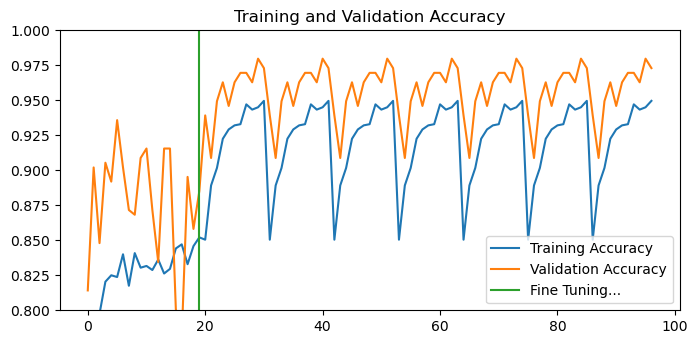

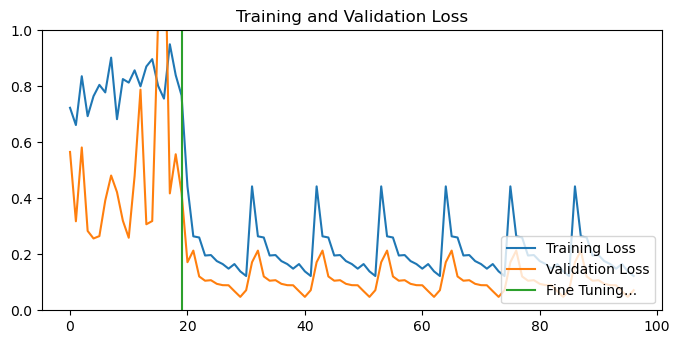

In [43]:
accuracy += history_fine.history['accuracy']
val_accuracy += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


# Training and Validation accuracy plot.
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Fine Tuning...')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


# Training and Validation loss plot
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Fine Tuning...')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

From the above plots we can deduce that the fine tuning session really did much good.  
However, I can also observe that I did not need as much epochs as I used.

### Some extracurricular testing
Let's play with the model...

We'll randomly select an image from _test_ds_; We'll plot this image then print it's actual label and predicted label.

Predicting this image...
Actual label: no_tumour
1/1 [==============================] - 1s 562ms/step
Predicted label: no_tumour 
Confidence: 100.0%


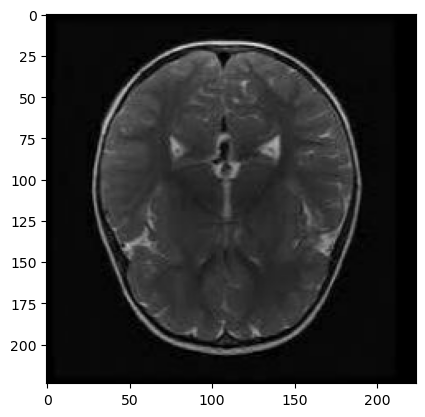

In [54]:
# Gets the label names from the dataset object.
label_names = dataset.class_names

for images_batch, labels_batch in test_ds.take(1):
    image = images_batch[0].numpy().astype("uint8")
    label = labels_batch[0].numpy()
    
    print("Predicting this image...")
    plt.imshow(image)
    print(f"Actual label: {label_names[label]}")
    
    predictions = model.predict(images_batch)
    predicted_label = label_names[np.argmax(predictions[0])]
    confidence = (round(np.max(predictions[0]), 2) * 100)
    print(f"Predicted label: {predicted_label} \nConfidence: {confidence}%")

I'll define a function that takes an image and returns the predicted label and confidence of the prediction.

In [47]:
def classify(model, img):
    
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    
    # Create a batch.
    image_array = tf.expand_dims(image_array, 0)
    
    # Get prediction.
    prediction = model.predict(image_array)
    
    # Get label name
    predicted_label = label_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    return predicted_label, confidence

Now, we can plot several images and get their predictions using the above function.

1/1 [==============================] - 0s 94ms/step


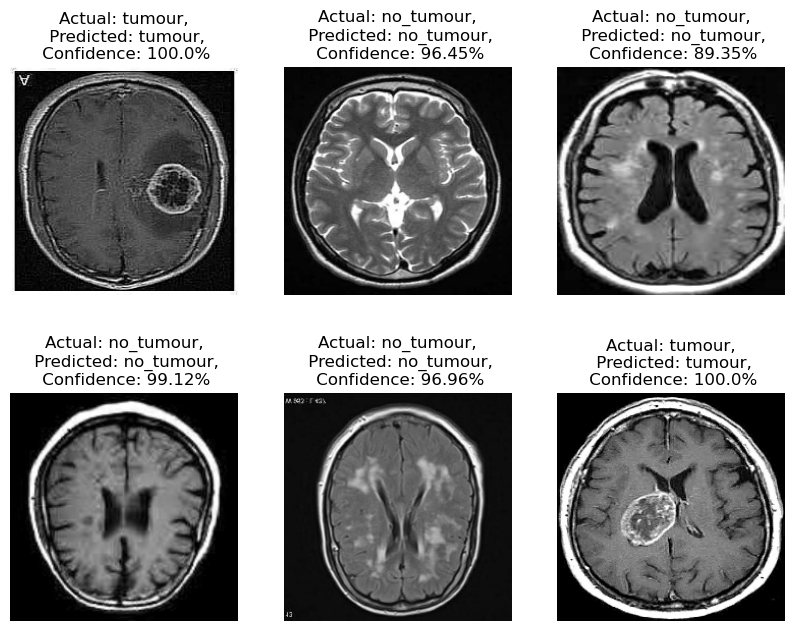

In [49]:
# Expand plot size.
plt.figure(figsize=(10, 12))

for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_label, confidence = classify(model, images[i].numpy())
        actual_label = label_names[labels[i]]
        
        plt.title(f"Actual: {actual_label},\n Predicted: {predicted_label},\n Confidence: {confidence}%")
        plt.axis("off")

Perfect!  
Everything is working fine.  
Let's go ahead and save the model.

In [52]:
model_version = 3
model.save(f"../saved_models/{model_version}")
model.save(r"../saved_models/brain_tumour.h5")

In [56]:
# ifunanyaScript